# Table of Contents
1. [Function for Hyperparameter Tuning and Computing Feature Importance](#hyperparameter-tuning)
2. [Generating Rainfall Status Column](#rainfall-status)
3. [Running Some Models to Measure Importance of Rainfall Status](#rainfall-models)
4. [Finding Correlation in Original ATM Data and Running Models by Dropping Correlated Columns](#atm-correlation)
5. [Amount Withdrawn as a Categorical Column](#categorical-output)
6. [Chi-Squared Test on Categorical Data](#chi-squared)
7. [Recursive Feature Elimination](#rfe)
8. [Chi-Squared Test on Categorical Data](#chi-squared)
9. [Hyperparameter Tuning on Categorical Models](#categorical-hyperparameter-tuning)
10. [Running Models using Sequential Train-Test Split](#sequential-train-test)


**Preparatory imports**

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 

%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve, cross_val_score, train_test_split

from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from regressors import stats # useful for determing p-values of each feature
from sklearn.feature_selection import chi2, RFE

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

## Pre-processing and cleaning
<p> Weather Data columns that were dropped beforehand because of high correlation include, maxtempC, HeatIndexC, WindChillC, tempC, WindGustKmph, DewPointC </p>

In [4]:
combined_data = pd.read_csv('../data/aggregated_atm_data_with_weather_data.csv ')
combined_data.drop(['No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals', 
                    'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card',
                    'maxtempC', 'HeatIndexC', 'WindChillC', 'tempC', 'WindGustKmph', 'DewPointC'], axis=1, inplace=True)

combined_data['Transaction Date'] = pd.to_datetime(combined_data['Transaction Date'])
combined_data['Day'] = combined_data['Transaction Date'].dt.day
combined_data['Month'] = combined_data['Transaction Date'].dt.month
combined_data['Year'] = combined_data['Transaction Date'].dt.year
combined_data.drop('Transaction Date', axis=1, inplace=True)

<p> Further columns dropped because of complications involving converting time to numeric values and avoiding generation of large number of dummy columns at the same time and just pure irrelevance as well too</p>

In [4]:
combined_data.drop(['moonrise', 'moonset', 'sunrise', 'sunset', 'winddirDegree', 'mintempC'], axis=1, inplace=True)

In [5]:
atm_names = combined_data['ATM Name'].unique()

In [6]:
categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 
                             'Month', 'Day', 'Year',
                            'uvIndex']

In [5]:
def convert_categorical_to_numerical(data, column_list):
    if 'ATM Name' in column_list:
        column_list.remove('ATM Name')
        temp_data = pd.get_dummies(data, columns=column_list , drop_first=True)
    
        # Do drop_first for all columns, except for ATM Name, because it becomes useful for accessing individual ATM test
        # data later on
        return pd.get_dummies(temp_data, columns=['ATM Name'])
    else:
        return pd.get_dummies(data, columns=column_list, drop_first=True)

<a name="hyperparameter-tuning"></a>
## Hyperparameter Tuning for Regression and evaluating feature importance too

## Different Functions for Training Tree_Models and Linear_Models to handle their different methods of getting feature importance 
<h3> Handled by sending the tree_model parameter as True to this function if it is Random Forest or Decision Tree and False if it is Linear Model </h3>
<h3> If it is neither Linear_Model or Tree, then send nothing for that parameter value and it will still work </h3>
<p> Note: Probably have to include another parameter to support Polynomial Regression Models </p>

<h3> 1. For Random Forest and Decision Tree </h3>

    Prints important features based on permutation_importance() function result
    And only displays those features whose importance is atleast twice more than the standard deviation of the 
    entire importance array
<h3> <a href="https://scikit-learn.org/stable/modules/permutation_importance.html"> Permutation Importance </a> </h3>

<h3> 2. For Linear_Models (Elasticnet, Bayesian Ridge, Lasso, Ridge, etc.) </h3>

    Prints p-values of all features (can be filtered down later)
    I used significance level as 5%, so if p-value < 0.05, only then would a feature be considered as important
<h3> <a href="https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/"> Reference </a> </h3>

<h3> A change that was made later on to the training function below is the Sequential Train-Test split which is quite an important change and its effects will not be visible on most of the models trained here because they were trained using the old Randomized Train-Test Split </h3>
<p> Here starting 70% of the rows are considered for training and remaining 30% is left for testing so as to avoid data leakage and make models more practical </p>


In [80]:
# Works for both RandomizedSearchCV() object and GridSearchCV() object
def model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, 
                                      param_cv_obj, tree_model='Invalid'):
    
    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)
    
    # Dropping Correlated Holiday Sequence columns (only temporarily used)
    # numeric_curr_atm_data.drop(['Holiday Sequence_HWW','Holiday Sequence_WHH','Holiday Sequence_HHW'], axis=1,inplace=True)
    
    # Not using 2016 and 2017 data so that testing can be done better
    # numeric_curr_atm_data = numeric_curr_atm_data[numeric_curr_atm_data.apply(lambda x: x['Year_2016'] != 1 and x['Year_2017'] != 1, axis=1)]
    
    X = numeric_curr_atm_data.drop('Total amount Withdrawn', axis=1)
    y = numeric_curr_atm_data['Total amount Withdrawn']
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
    # Splitting data sequentially as 70% train and 30% test
    train_size = int(0.7 * len(X))
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    param_cv_obj.fit(X_train, y_train)
    print("Best Parameters:\n", param_cv_obj.best_params_)
    print("\nBest CV RMSE:", -param_cv_obj.best_score_)
    
    if 'mean_train_score' in param_cv_obj.cv_results_:
        # nanmean() is used here instead of mean() because for DecisionTree the mean_train_score actually contains nan
        # for some reason, so nanmean() ignores it while computing mean
        print("Best Training RMSE:", -np.nanmean(param_cv_obj.cv_results_['mean_train_score']))
    
    best_model = param_cv_obj.best_estimator_
    model_predictions = best_model.predict(X_test)
    model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
    model_mape = mean_absolute_percentage_error(y_test, model_predictions)
    
    print("Test RMSE:", model_rmse)
    print("Test MAPE:", model_mape)
    
    column_names = X_train.columns
    
    if tree_model == False:
        # p_val_array[1:] because 0-th index is reserved for intercept p-val which is not required for us
        try:
            p_val_array = stats.coef_pval(best_model, X_train, y_train)
            [print("{} : {}".format(x, y)) for x, y in zip(column_names, p_val_array[1:]) if y < 0.05]
        except:
            pass
        
    elif tree_model == True:
        r = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=0)
        for i in r.importances_mean.argsort()[::-1]:
            if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
                print(f"{column_names[i]:<8}: "
                      f"{r.importances_mean[i]:.3f}"
                      f" +/- {r.importances_std[i]:.3f}")
        
    print("------------------------------------------------------------------------\n")    

<h3> Running Random Forest after dropping all correlated weather features </h3>

In [9]:
rforest_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
                      'min_samples_split': list(range(1,40)), 'min_samples_leaf': list(range(1,25))}
                      
random_cv_rforest = RandomizedSearchCV(RandomForestRegressor(), rforest_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)


for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, combined_data, categorical_features_list, 
                                      random_cv_rforest, test_split=True, tree_model=True)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 14.6min finished


Best Parameters:
 {'n_estimators': 600, 'min_samples_split': 22, 'min_samples_leaf': 1}

Best CV RMSE: 109314.54789524553
Best Training RMSE: 93625.1221674905
Test RMSE: 115701.71721069398
Year_2015: 0.498 +/- 0.027
Year_2016: 0.480 +/- 0.032
Year_2014: 0.426 +/- 0.036
Year_2013: 0.269 +/- 0.022
Year_2017: 0.191 +/- 0.021
Year_2012: 0.106 +/- 0.013
Month_11: 0.036 +/- 0.010
Day_11  : 0.019 +/- 0.007
Day_12  : 0.016 +/- 0.005
Day_3   : 0.007 +/- 0.004
Day_10  : 0.007 +/- 0.002
Month_5 : 0.004 +/- 0.002
Day_7   : 0.002 +/- 0.001
------------------------------------------------------------------------


For Mount Road ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 12.8min finished


Best Parameters:
 {'n_estimators': 1400, 'min_samples_split': 25, 'min_samples_leaf': 1}

Best CV RMSE: 182399.0352807436
Best Training RMSE: 157830.31245451362
Test RMSE: 184320.87860949992
Year_2016: 0.433 +/- 0.037
Year_2017: 0.254 +/- 0.035
Holiday Sequence_HHW: 0.054 +/- 0.014
Weekday_SUNDAY: 0.047 +/- 0.010
Year_2014: 0.039 +/- 0.008
Day_4   : 0.032 +/- 0.007
moon_illumination: 0.025 +/- 0.006
Year_2015: 0.024 +/- 0.004
Day_10  : 0.020 +/- 0.008
FeelsLikeC: 0.019 +/- 0.005
Festival Religion_NH: 0.018 +/- 0.008
Year_2012: 0.014 +/- 0.006
Day_7   : 0.007 +/- 0.003
Day_12  : 0.007 +/- 0.002
Month_7 : 0.007 +/- 0.001
Day_9   : 0.006 +/- 0.002
Day_8   : 0.005 +/- 0.002
Holiday Sequence_WHH: 0.004 +/- 0.001
Day_30  : 0.002 +/- 0.001
Year_2013: 0.002 +/- 0.001
Holiday Sequence_WWW: 0.001 +/- 0.001
uvIndex_5: 0.001 +/- 0.000
Festival Religion_N: 0.000 +/- 0.000
Festival Religion_M: 0.000 +/- 0.000
uvIndex_8: 0.000 +/- 0.000
----------------------------------------------------------------

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 15.0min finished


Best Parameters:
 {'n_estimators': 800, 'min_samples_split': 32, 'min_samples_leaf': 1}

Best CV RMSE: 172611.0344381951
Best Training RMSE: 146700.3384219197
Test RMSE: 166132.26169151615
Year_2016: 0.270 +/- 0.037
Year_2017: 0.119 +/- 0.021
Year_2013: 0.054 +/- 0.011
Weekday_SATURDAY: 0.053 +/- 0.009
Year_2012: 0.035 +/- 0.005
Day_8   : 0.029 +/- 0.014
moon_illumination: 0.028 +/- 0.010
Month_9 : 0.017 +/- 0.006
humidity: 0.013 +/- 0.006
FeelsLikeC: 0.012 +/- 0.006
Year_2014: 0.008 +/- 0.002
Holiday Sequence_WHH: 0.007 +/- 0.004
Year_2015: 0.007 +/- 0.003
cloudcover: 0.007 +/- 0.003
Day_11  : 0.005 +/- 0.001
Day_27  : 0.001 +/- 0.001
------------------------------------------------------------------------


For KK Nagar ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 14.1min finished


Best Parameters:
 {'n_estimators': 1200, 'min_samples_split': 35, 'min_samples_leaf': 3}

Best CV RMSE: 308562.9889931216
Best Training RMSE: 276377.2028885728
Test RMSE: 294645.7856796624
Year_2014: 0.373 +/- 0.035
Year_2013: 0.352 +/- 0.044
Year_2012: 0.238 +/- 0.029
Weekday_SUNDAY: 0.238 +/- 0.038
moon_illumination: 0.032 +/- 0.007
Year_2015: 0.026 +/- 0.005
Year_2017: 0.024 +/- 0.006
Year_2016: 0.023 +/- 0.005
Day_11  : 0.016 +/- 0.007
Festival Religion_NH: 0.015 +/- 0.003
Day_6   : 0.014 +/- 0.003
FeelsLikeC: 0.013 +/- 0.004
Day_12  : 0.013 +/- 0.004
Day_2   : 0.008 +/- 0.002
Day_31  : 0.003 +/- 0.001
Day_7   : 0.002 +/- 0.001
Month_4 : 0.001 +/- 0.001
Month_7 : 0.001 +/- 0.001
Holiday Sequence_HWW: 0.001 +/- 0.001
Day_29  : 0.001 +/- 0.000
Day_30  : 0.000 +/- 0.000
------------------------------------------------------------------------


For Christ College ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 17.2min finished


Best Parameters:
 {'n_estimators': 2000, 'min_samples_split': 14, 'min_samples_leaf': 2}

Best CV RMSE: 212747.75622138512
Best Training RMSE: 180204.94309515107
Test RMSE: 208389.22232297878
Year_2014: 0.367 +/- 0.035
Year_2017: 0.308 +/- 0.042
Year_2016: 0.178 +/- 0.020
Holiday Sequence_HHW: 0.172 +/- 0.049
Year_2013: 0.138 +/- 0.012
Year_2015: 0.102 +/- 0.012
moon_illumination: 0.081 +/- 0.019
Year_2012: 0.024 +/- 0.004
Festival Religion_NH: 0.023 +/- 0.007
Day_10  : 0.018 +/- 0.003
Day_8   : 0.018 +/- 0.004
Day_9   : 0.010 +/- 0.004
Day_2   : 0.007 +/- 0.003
Day_12  : 0.005 +/- 0.002
Day_11  : 0.005 +/- 0.002
Day_14  : 0.000 +/- 0.000
Day_25  : 0.000 +/- 0.000
------------------------------------------------------------------------



<h3> I would say this is quite overfitting behaviour, which is why the conclusion was to just use the Precipitation column </h3>
<b> <p> Note: moon_illumination and FeelsLikeC are two columns that showed up quite consistently on all ATMs except Big Street, so that is something to consider for the future, once we are back to considering other ATMs as well </p> <b>

<a name="rainfall-status"></a>
# Converting Precipitation to Rain Status based on the conditions described in next cell
<h4> Source: Wikipedia </h4>

    Light rain — when the precipitation rate is < 2.5 mm (0.098 in) per hour
    Moderate rain — when the precipitation rate is between 2.5 mm (0.098 in) - 7.6 mm (0.30 in) or 10 mm (0.39 in) per hour
    Heavy rain — when the precipitation rate is > 7.6 mm (0.30 in) per hour or between 10 mm (0.39 in) and 50 mm (2.0 in) per hour
    Violent rain — when the precipitation rate is > 50 mm (2.0 in) per hour

In [74]:
def rainfall_status_check(value):
    if value == 0:
        return "No Rain"
    elif value < 2.5:
        return "Light Rain"
    elif value <= 7.6:
        return "Moderate Rain"
    elif value <= 50:
        return "Heavy Rain"
    else:
        return "Violent Rain"

In [5]:
combined_data = pd.read_csv('../data/aggregated_atm_data_with_weather_data.csv ')
combined_data.drop(['No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals', 
                    'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card',
                    'maxtempC', 'HeatIndexC', 'WindChillC', 'tempC', 'WindGustKmph', 'DewPointC'], axis=1, inplace=True)

combined_data['Transaction Date'] = pd.to_datetime(combined_data['Transaction Date'])
combined_data['Day'] = combined_data['Transaction Date'].dt.day
combined_data['Month'] = combined_data['Transaction Date'].dt.month
combined_data['Year'] = combined_data['Transaction Date'].dt.year
combined_data.drop('Transaction Date', axis=1, inplace=True)

In [73]:
combined_data.drop(['moonrise', 'moonset', 'sunrise', 'sunset', 'winddirDegree', 
                    'mintempC', 'uvIndex', 'sunHour', 'FeelsLikeC', 'cloudcover',
                   'humidity', 'pressure', 'visibility', 'winddirDegree', 
                    'windspeedKmph', 'moon_illumination'], axis=1, inplace=True)

In [ ]:
combined_data['Rainfall_Status'] = combined_data['precipMM'].apply(rainfall_status_check)
combined_data.drop('precipMM', axis=1, inplace=True)

<a name="rainfall-models"></a>
# Running some models and noting observations wrt Rainfall Status

# Random Forest

In [13]:
rforest_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
                      'min_samples_split': list(range(1,40)), 'min_samples_leaf': list(range(1,25))}
                      
random_cv_rforest = RandomizedSearchCV(RandomForestRegressor(), rforest_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)


for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, combined_data, categorical_features_list, 
                                      random_cv_rforest, tree_model=True)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 18.7min finished


Best Parameters:
 {'n_estimators': 1000, 'min_samples_split': 39, 'min_samples_leaf': 2}

Best CV RMSE: 112816.58935483606
Best Training RMSE: 106672.16244204574
Test RMSE: 107623.11851981132
Year_2016: 0.558 +/- 0.039
Year_2015: 0.524 +/- 0.041
Year_2014: 0.443 +/- 0.034
Year_2013: 0.297 +/- 0.019
Year_2017: 0.246 +/- 0.025
Year_2012: 0.133 +/- 0.017
Month_11: 0.053 +/- 0.018
Day_6   : 0.035 +/- 0.006
Day_11  : 0.029 +/- 0.006
Month_12: 0.017 +/- 0.004
Day_12  : 0.015 +/- 0.005
Month_7 : 0.012 +/- 0.003
Day_8   : 0.008 +/- 0.003
Month_10: 0.005 +/- 0.002
Month_9 : 0.005 +/- 0.002
Day_15  : 0.002 +/- 0.001
------------------------------------------------------------------------


For Mount Road ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.7min finished


Best Parameters:
 {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 2}

Best CV RMSE: 181249.0350285287
Best Training RMSE: 174702.06969810874
Test RMSE: 188249.73294382586
Year_2017: 0.266 +/- 0.038
Year_2016: 0.254 +/- 0.032
Holiday Sequence_HHW: 0.066 +/- 0.016
Weekday_SUNDAY: 0.065 +/- 0.015
Year_2014: 0.042 +/- 0.011
Day_10  : 0.039 +/- 0.009
Festival Religion_NH: 0.036 +/- 0.008
Year_2015: 0.035 +/- 0.012
Day_4   : 0.031 +/- 0.010
Year_2012: 0.022 +/- 0.006
Day_11  : 0.021 +/- 0.007
Year_2013: 0.018 +/- 0.004
Month_11: 0.018 +/- 0.008
Day_6   : 0.013 +/- 0.003
Day_12  : 0.011 +/- 0.004
Day_8   : 0.008 +/- 0.003
Day_3   : 0.008 +/- 0.003
Day_31  : 0.006 +/- 0.003
Day_25  : 0.004 +/- 0.002
Holiday Sequence_WHW: 0.002 +/- 0.001
Day_14  : 0.001 +/- 0.000
------------------------------------------------------------------------


For Airport ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 13.3min finished


Best Parameters:
 {'n_estimators': 1200, 'min_samples_split': 38, 'min_samples_leaf': 1}

Best CV RMSE: 173230.61922801757
Best Training RMSE: 162254.069726282
Test RMSE: 160181.18813325328
Year_2016: 0.263 +/- 0.043
Year_2017: 0.168 +/- 0.019
Day_8   : 0.073 +/- 0.010
Weekday_SATURDAY: 0.054 +/- 0.010
Year_2013: 0.051 +/- 0.012
Holiday Sequence_WHH: 0.050 +/- 0.009
Year_2012: 0.049 +/- 0.006
Year_2014: 0.025 +/- 0.009
Day_4   : 0.023 +/- 0.007
Holiday Sequence_HHW: 0.019 +/- 0.005
Day_10  : 0.018 +/- 0.003
Month_11: 0.017 +/- 0.007
Day_7   : 0.016 +/- 0.006
Year_2015: 0.014 +/- 0.003
Weekday_SUNDAY: 0.013 +/- 0.006
Day_3   : 0.012 +/- 0.004
Day_9   : 0.011 +/- 0.004
Day_5   : 0.009 +/- 0.003
Day_11  : 0.008 +/- 0.002
Day_2   : 0.005 +/- 0.002
------------------------------------------------------------------------


For KK Nagar ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 13.2min finished


Best Parameters:
 {'n_estimators': 1400, 'min_samples_split': 10, 'min_samples_leaf': 3}

Best CV RMSE: 302002.80820304784
Best Training RMSE: 298619.72650276637
Test RMSE: 303636.6591586358
Year_2014: 0.391 +/- 0.045
Year_2013: 0.234 +/- 0.033
Weekday_SUNDAY: 0.219 +/- 0.035
Year_2012: 0.202 +/- 0.026
Year_2016: 0.055 +/- 0.005
Year_2017: 0.053 +/- 0.009
Year_2015: 0.037 +/- 0.007
Day_11  : 0.030 +/- 0.010
Day_6   : 0.025 +/- 0.007
Day_12  : 0.020 +/- 0.005
Month_12: 0.020 +/- 0.009
Day_4   : 0.020 +/- 0.004
Month_11: 0.019 +/- 0.005
Rainfall_Status_No Rain: 0.015 +/- 0.005
Day_2   : 0.015 +/- 0.004
Festival Religion_NH: 0.015 +/- 0.004
Month_9 : 0.010 +/- 0.002
Day_5   : 0.009 +/- 0.002
Day_7   : 0.005 +/- 0.002
Festival Religion_H: 0.004 +/- 0.001
------------------------------------------------------------------------


For Christ College ATM
Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 18.3min finished


Best Parameters:
 {'n_estimators': 2000, 'min_samples_split': 38, 'min_samples_leaf': 1}

Best CV RMSE: 211994.60822291044
Best Training RMSE: 205249.91545336385
Test RMSE: 205222.78361222986
Year_2017: 0.391 +/- 0.032
Year_2014: 0.280 +/- 0.030
Year_2016: 0.230 +/- 0.022
Year_2015: 0.116 +/- 0.011
Year_2013: 0.087 +/- 0.010
Weekday_SUNDAY: 0.064 +/- 0.019
Day_9   : 0.053 +/- 0.012
Holiday Sequence_HHW: 0.053 +/- 0.018
Day_10  : 0.046 +/- 0.011
Festival Religion_NH: 0.046 +/- 0.008
Year_2012: 0.032 +/- 0.004
Day_3   : 0.031 +/- 0.010
Day_12  : 0.020 +/- 0.008
Day_7   : 0.019 +/- 0.004
Day_6   : 0.016 +/- 0.006
Day_11  : 0.013 +/- 0.004
Month_5 : 0.013 +/- 0.004
Day_5   : 0.012 +/- 0.004
Month_12: 0.009 +/- 0.004
Day_24  : 0.006 +/- 0.002
Rainfall_Status_Light Rain: 0.003 +/- 0.001
Day_25  : 0.001 +/- 0.000
------------------------------------------------------------------------



<h3> Observations </h3>
<p> Rainfall_Status_No Rain was considered important for KK Nagar and Light Rain was considered important for Christ College </p>

# Lasso

In [52]:
lasso_param_grid = {'alpha':np.logspace(-3, 3, num=50)}
grid_cv_lasso = GridSearchCV(Lasso(max_iter=2000), lasso_param_grid, verbose=2, n_jobs=-1, 
                             scoring='neg_root_mean_squared_error', cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, combined_data, categorical_features_list, 
                                      grid_cv_lasso, tree_model=False)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   36.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'alpha': 59.636233165946365}

Best CV RMSE: 112630.17385915112
Best Training RMSE: 108532.55394962615
Test RMSE: 122163.08665723335
Weekday_MONDAY : 0.010215504696719169
Weekday_SATURDAY : 0.00866704255214934
Weekday_THURSDAY : 0.00011404167149864364
Weekday_TUESDAY : 1.940198419014827e-05
Weekday_WEDNESDAY : 0.00037055606897440363
Festival Religion_N : 0.04897152560495854
Holiday Sequence_HHW : 0.02624602938471088
Holiday Sequence_WHW : 0.005615772500587424
Month_10 : 0.00888268840845341
Month_12 : 0.001875861535828749
Day_6 : 0.00018887944996959227
Day_8 : 0.00040569757736319545
Day_9 : 9.232053499452775e-08
Day_11 : 1.3372975548042731e-05
Day_12 : 3.777866325926915e-05
Day_17 : 0.023746417044392176
Day_19 : 0.03697907225608166
Day_22 : 0.01752059621659985
Day_23 : 0.005602571784383947
Day_24 : 0.0005476836561728593
Day_25 : 0.030891116407624875
Day_27 : 0.008492612562490676
Day_31 : 0.01259509885411969
Year_2012 : 0.0
Year_2013 : 0.0
Year_2014 : 0.0
Year_2015 : 0.

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   46.0s finished


Best Parameters:
 {'alpha': 25.595479226995334}

Best CV RMSE: 180412.67859863336
Best Training RMSE: 173753.3751367989
Test RMSE: 171331.6212584216
Weekday_SATURDAY : 6.861982093653296e-09
Weekday_THURSDAY : 0.01626872430344206
Weekday_TUESDAY : 0.027708424691027966
Weekday_WEDNESDAY : 0.009905803996809848
Working Day_W : 0.04451337629502805
Month_2 : 0.00260053840122354
Month_3 : 0.0037890498101864623
Month_4 : 6.0621888575473903e-05
Month_5 : 1.6210051967391337e-08
Month_6 : 2.2990720123239328e-06
Month_7 : 0.0002438769287840259
Month_8 : 0.00025151312256777025
Month_9 : 0.00505344489322157
Month_10 : 0.0011136481526341502
Month_11 : 0.0035270907082214364
Day_5 : 0.0010346265960590184
Day_6 : 0.005011191149993266
Day_8 : 0.03194955657413834
Day_10 : 0.018292765136263434
Day_12 : 0.03662699593646668
Day_13 : 6.267586449837381e-11
Day_14 : 1.2034262475424384e-09
Day_15 : 2.850608638027552e-12
Day_16 : 1.1457501614131615e-13
Day_17 : 4.083636317986361e-09
Day_18 : 3.842481888227667e-12

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   31.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'alpha': 14.563484775012444}

Best CV RMSE: 175951.8910828563
Best Training RMSE: 169021.99819178137
Test RMSE: 166343.46801016547
Weekday_MONDAY : 0.045546383108879596
Weekday_SATURDAY : 1.7042277367096403e-08
Weekday_THURSDAY : 0.013242663554440925
Weekday_WEDNESDAY : 0.0004475997526185438
Festival Religion_NH : 0.006838182166031936
Holiday Sequence_HHW : 7.52455520516282e-05
Holiday Sequence_WHH : 1.897866365041523e-05
Holiday Sequence_WHW : 0.00037425477881947167
Holiday Sequence_WWH : 0.009387103742149572
Holiday Sequence_WWW : 0.019483412363266117
Month_3 : 0.008398183789082525
Month_11 : 0.020965934184914436
Month_12 : 0.015552466402270593
Day_6 : 0.011407730938728378
Day_8 : 0.0011028712008140928
Day_13 : 0.025161644412145412
Day_15 : 0.020782808352020066
Day_16 : 0.017516290760142272
Day_17 : 0.00018249298877104358
Day_18 : 0.010849241854109293
Day_19 : 0.0019369398888868794
Day_21 : 0.0019799150249175668
Day_22 : 0.00010296631204975704
Day_23 : 0.0058814239

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameters:
 {'alpha': 244.205309454865}

Best CV RMSE: 330303.86291344377
Best Training RMSE: 317230.2062928679
Test RMSE: 282049.6082596437
Weekday_SUNDAY : 0.0014201825171547
Weekday_THURSDAY : 0.024749735454979715
Weekday_WEDNESDAY : 4.705073940258764e-05
Festival Religion_H : 0.013258934831487101
Month_7 : 0.00014594922622523931
Month_8 : 0.02179615822324954
Month_9 : 0.0010420858806974298
Month_11 : 1.616243123336858e-06
Month_12 : 3.0718526485618014e-05
Day_6 : 9.122397664085291e-05
Day_10 : 0.03487651614282283
Day_13 : 0.002930709741018056
Day_14 : 0.0041231308111380205
Day_15 : 0.035304931734213785
Day_16 : 0.0009793143637746304
Day_17 : 0.005155359408414828
Day_18 : 1.1483229366504588e-05
Day_19 : 0.00027242556154938313
Day_20 : 0.003241598634743159
Day_21 : 0.001666795118229203
Day_22 : 2.34915862504792e-05
Day_23 : 1.7508529788212712e-06
Day_24 : 9.022278908421555e-07
Day_25 : 0.0009004944287178684
Day_26 : 0.04666362815751657
Day_27 : 0.00023558374792176373
Day_28 : 0

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


Best Parameters:
 {'alpha': 323.745754281764}

Best CV RMSE: 205793.70928000356
Best Training RMSE: 197960.62402210344
Test RMSE: 216009.7685643173
Weekday_SATURDAY : 6.634668370253394e-10
Working Day_W : 0.002645075414979159
Month_11 : 0.026469398118280196
Month_12 : 7.5735798754639205e-06
Day_2 : 0.000444758338861595
Day_3 : 6.255280767164528e-05
Day_7 : 2.937409574244043e-05
Day_9 : 2.2575059599461156e-09
Day_10 : 1.8244017452317962e-07
Day_11 : 0.026153433888923994
Day_12 : 0.01038255225560536
Day_16 : 0.026274080049645265
Day_18 : 0.0019509079065815893
Day_22 : 0.018415620909579822
Day_23 : 0.0018193416491383285
Day_24 : 0.004183484485745348
Day_25 : 0.002587965304453821
Day_26 : 0.000989874257422585
Day_28 : 0.009934274594911141
Day_29 : 0.028373797913520127
Year_2012 : 0.0
Year_2013 : 0.0
Year_2014 : 0.0
Year_2015 : 0.0
Year_2016 : 0.0
Year_2017 : 0.0
------------------------------------------------------------------------



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


<h3> Observations </h3>
<p> No Rain feature was important for Airport ATM </p>

# Elasticnet

In [53]:
elastic_param_grid = {'l1_ratio': [.1, .5, .7, .9, .95, .99, 1], 'alpha': np.logspace(-3, 3, num=50)}
                      
grid_cv_elastic = GridSearchCV(ElasticNet(max_iter=10000), elastic_param_grid, n_jobs=-1,
                                       scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, combined_data, categorical_features_list, 
                                      grid_cv_elastic, tree_model=False)


For Big Street ATM
Using Train-Test Split
Fitting 10 folds for each of 350 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1029 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1502 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2562 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  4.7min finished


Best Parameters:
 {'alpha': 184.20699693267164, 'l1_ratio': 1}

Best CV RMSE: 117120.81659016541
Best Training RMSE: 133002.48953436076
Test RMSE: 105469.894994206
Month_10 : 0.036928669650658996
Month_12 : 0.0012397494194062997
Day_6 : 6.063782082166291e-05
Day_8 : 0.007682762774576579
Day_9 : 8.186418514632976e-06
Day_10 : 0.039221732889387795
Day_11 : 0.003945024118934715
Day_12 : 0.0005443593273135594
Day_23 : 0.02233437663137816
Day_24 : 0.004304674976187917
Day_31 : 0.030517573858798164
Year_2012 : 0.0
Year_2013 : 0.0
Year_2014 : 0.0
Year_2015 : 0.0
Year_2016 : 0.0
Year_2017 : 0.0
------------------------------------------------------------------------


For Mount Road ATM
Using Train-Test Split
Fitting 10 folds for each of 350 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1033 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1740 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3436 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  3.0min finished


Best Parameters:
 {'alpha': 0.0013257113655901094, 'l1_ratio': 0.9}

Best CV RMSE: 178362.6017093229
Best Training RMSE: 206656.53595452415
Test RMSE: 178703.98665589714
Weekday_MONDAY : 0.023517739143683825
Weekday_SATURDAY : 5.308377293289368e-09
Weekday_THURSDAY : 0.014185025175857291
Weekday_WEDNESDAY : 0.016846711782082302
Holiday Sequence_WHH : 0.0020911725520949
Holiday Sequence_WHW : 0.017210937990383757
Month_2 : 0.0022205758245590346
Month_3 : 0.00023253933874878285
Month_4 : 0.0008901308548059372
Month_5 : 5.167542838080408e-09
Month_6 : 4.763015653441727e-06
Month_7 : 3.247625946656285e-05
Month_8 : 1.1746157464909146e-05
Month_9 : 0.012041096912965843
Month_10 : 2.5853297436873035e-05
Month_11 : 0.006620787035289899
Day_5 : 0.0017642718581800665
Day_6 : 0.013956350302795295
Day_10 : 0.01755526843073829
Day_12 : 0.041075055423744455
Day_13 : 2.7588820117330215e-11
Day_14 : 5.37492272911777e-10
Day_15 : 1.7763568394002505e-15
Day_16 : 1.4210854715202004e-14
Day_17 : 1.055373

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1134 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2316 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  2.5min finished


Best Parameters:
 {'alpha': 0.016768329368110083, 'l1_ratio': 0.9}

Best CV RMSE: 172219.5949347741
Best Training RMSE: 180374.2381694476
Test RMSE: 176507.27764668778
Weekday_SATURDAY : 1.413662831217799e-05
Weekday_THURSDAY : 0.010241926205528662
Weekday_TUESDAY : 0.004985425289880441
Weekday_WEDNESDAY : 0.00010247957732500979
Holiday Sequence_HHW : 0.007703852267673117
Holiday Sequence_WHH : 0.015415770799978468
Month_3 : 0.007442817550058489
Day_6 : 0.003403310872143628
Day_8 : 6.556516472522311e-05
Day_17 : 0.00115958422939344
Day_19 : 0.010104968823720473
Day_21 : 0.028660805001903045
Day_22 : 0.011755105562079482
Day_23 : 0.022335631617338203
Day_24 : 0.0006813192698471582
Day_25 : 0.0011981530390992035
Day_26 : 0.00363138973528887
Day_27 : 0.037983283239339194
Day_28 : 0.02885079216729869
Year_2012 : 1.1524114995609125e-13
Year_2013 : 0.0
Year_2014 : 8.382504845805272e-08
Year_2016 : 0.0
Year_2017 : 4.2521541843143495e-13
Rainfall_Status_No Rain : 0.00958458450549693
----------

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1066 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3493 out of 3500 | elapsed:  2.8min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  2.8min finished


Best Parameters:
 {'alpha': 138.9495494373136, 'l1_ratio': 1}

Best CV RMSE: 319415.9474317678
Best Training RMSE: 358754.0167849929
Test RMSE: 324383.60139011074
Weekday_SATURDAY : 0.012890522351922451
Weekday_SUNDAY : 0.0038099957239841054
Weekday_WEDNESDAY : 8.375859983056344e-05
Festival Religion_H : 0.0028545213871280506
Month_7 : 0.0018267539172480696
Month_8 : 0.03195359532316622
Month_9 : 0.0010164530557272844
Month_11 : 6.633620331619738e-05
Month_12 : 9.744581634119065e-05
Day_3 : 0.04272531297450666
Day_6 : 5.576301683496432e-05
Day_10 : 0.03401890548895481
Day_13 : 0.011819678812314383
Day_14 : 0.003532594428486968
Day_15 : 0.007308278874826879
Day_16 : 0.00016491392248108028
Day_17 : 0.004668216960773908
Day_18 : 4.307503511213895e-06
Day_19 : 0.0011511144317895017
Day_20 : 5.537431835356266e-05
Day_21 : 0.00010409627972784996
Day_22 : 2.8486483162337706e-05
Day_23 : 3.1523242416398034e-07
Day_24 : 4.8731085389164264e-08
Day_25 : 9.493381774361431e-05
Day_26 : 0.0076174492

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1190 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2356 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  3.3min finished


Best Parameters:
 {'alpha': 79.06043210907701, 'l1_ratio': 1}

Best CV RMSE: 205758.14515699263
Best Training RMSE: 231558.75738095987
Test RMSE: 211465.06693700317
Weekday_SATURDAY : 8.999485334726387e-08
Weekday_THURSDAY : 0.007677831413104075
Weekday_TUESDAY : 0.025859335904005576
Weekday_WEDNESDAY : 0.002875754513126827
Working Day_W : 0.009671643239418382
Month_11 : 0.0036648163722450278
Month_12 : 6.577911029204131e-07
Day_2 : 0.016430619609968167
Day_3 : 0.014933512790510584
Day_7 : 0.004765475445811074
Day_8 : 0.03435571778403501
Day_9 : 3.807258420307491e-06
Day_10 : 0.00014007943930849365
Day_14 : 0.0005309250604033089
Day_15 : 0.012113985735562993
Day_16 : 2.8231564217717775e-05
Day_17 : 0.0019378956512172696
Day_18 : 3.326483555654569e-05
Day_19 : 0.0004853547131293823
Day_20 : 0.0008686075827897266
Day_21 : 0.0003753987480878962
Day_22 : 2.910020112878442e-06
Day_23 : 5.032558543227594e-07
Day_24 : 6.296247967441104e-10
Day_25 : 3.2687881845738787e-07
Day_26 : 6.6106560225

<h3> Observations </h3>

<p> No Rain was important for Mount Road & Airport ATMs and all Rain values were important for KK Nagar </p>

# Ridge Again

In [54]:
ridge_param_grid = {'alpha':np.logspace(-3, 3, num=50)}
grid_cv_ridge = GridSearchCV(Ridge(), ridge_param_grid, verbose=5, n_jobs=-1, scoring='neg_root_mean_squared_error'
                            ,return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, combined_data, categorical_features_list, 
                                      grid_cv_ridge, tree_model=False)


For Big Street ATM
Using Train-Test Split
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.5s finished


Best Parameters:
 {'alpha': 1.151395399326447}

Best CV RMSE: 114681.27841416541
Best Training RMSE: 117167.78424163599
Test RMSE: 113786.5039892505
Weekday_MONDAY : 0.0010166890666045703
Weekday_SATURDAY : 0.00043965315963800933
Weekday_SUNDAY : 0.0013304444136701399
Weekday_THURSDAY : 5.729465487824825e-06
Weekday_TUESDAY : 5.562616629539718e-07
Weekday_WEDNESDAY : 2.79659781265984e-06
Holiday Sequence_WHW : 0.011086012994069971
Month_10 : 0.0048228635198204195
Month_12 : 0.0007968111205745032
Day_6 : 0.00017953352204358453
Day_8 : 0.002326863190967643
Day_9 : 4.539530129576974e-07
Day_10 : 0.016556384962532977
Day_11 : 8.420229502781318e-05
Day_12 : 4.970215652155829e-06
Day_17 : 0.006412498128798738
Day_19 : 0.044728761371112036
Day_22 : 0.03966087896066317
Day_23 : 0.00294437737501152
Day_24 : 0.0002364395625411575
Day_27 : 0.026655015627748968
Day_28 : 0.04298192809714596
Day_31 : 0.020957185010464174
Year_2012 : 0.0
Year_2013 : 0.0
Year_2014 : 0.0
Year_2015 : 0.0
Year_2016 : 0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.3s finished


Best Parameters:
 {'alpha': 0.655128556859551}

Best CV RMSE: 176859.31450297261
Best Training RMSE: 179356.8331795557
Test RMSE: 187888.45284598155
Weekday_SATURDAY : 2.995979297981677e-07
Working Day_W : 0.04189957779849074
Holiday Sequence_WHH : 0.009009594717152014
Month_2 : 0.0004659955058994303
Month_3 : 0.004662414412291094
Month_4 : 2.7497785478614034e-05
Month_5 : 6.438085176085906e-09
Month_6 : 1.2133434748040628e-06
Month_7 : 0.00015388153809303695
Month_8 : 0.0002135998147247964
Month_9 : 0.001487691520740686
Month_10 : 0.0012933714270604302
Month_11 : 0.008770358605602269
Day_5 : 0.0117190576464139
Day_10 : 8.526003625775047e-06
Day_13 : 1.4780950492454537e-06
Day_14 : 4.7582769147069826e-07
Day_15 : 4.1902703529217433e-11
Day_16 : 6.38493702354026e-11
Day_17 : 4.4515946484580127e-10
Day_18 : 2.1834447583302108e-09
Day_19 : 5.049694631331647e-07
Day_20 : 3.94006867288077e-06
Day_21 : 1.9253287852905032e-09
Day_22 : 1.627609158560972e-11
Day_23 : 2.2355894913062002e-11
Day_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    3.9s finished


Best Parameters:
 {'alpha': 8.286427728546842}

Best CV RMSE: 174920.52500269053
Best Training RMSE: 171726.11624543567
Test RMSE: 168895.8449238915
Weekday_SATURDAY : 0.0019302720997622647
Weekday_THURSDAY : 0.03752063557629137
Weekday_WEDNESDAY : 0.004650390594211462
Month_3 : 0.018272809144738167
Day_6 : 0.020263891475089668
Day_7 : 0.015763564002986508
Day_8 : 1.906161978815213e-05
Day_11 : 0.018564893205397226
Day_17 : 0.0258460856898437
Day_24 : 0.015729542094147675
Day_25 : 0.03836724022871163
Day_31 : 0.04470981668048024
Year_2012 : 2.4771296125436493e-12
Year_2013 : 2.4424906541753444e-15
Year_2014 : 2.7905877608702667e-09
Year_2016 : 0.0
Year_2017 : 1.1123990617534218e-11
------------------------------------------------------------------------


For KK Nagar ATM
Using Train-Test Split
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.6s finished


Best Parameters:
 {'alpha': 6.25055192527397}

Best CV RMSE: 323715.8607767902
Best Training RMSE: 322602.97428327886
Test RMSE: 315513.52459795785
Weekday_SATURDAY : 0.008045606420807427
Weekday_SUNDAY : 0.0034115787216719706
Weekday_THURSDAY : 0.018855015755100624
Weekday_TUESDAY : 0.024492241286180327
Weekday_WEDNESDAY : 2.4011322504069454e-05
Month_7 : 0.0009923776706697307
Month_8 : 0.03651133395293038
Month_9 : 0.0007468138401964808
Month_11 : 1.8664391374656475e-06
Month_12 : 0.0001543697560721924
Day_6 : 1.2354422476157367e-06
Day_7 : 0.019207896861774154
Day_10 : 0.0005996978302709177
Day_18 : 0.0029905844350186506
Day_19 : 0.007917694484409488
Day_20 : 0.011078026648467576
Day_21 : 0.005741642194189822
Day_22 : 0.00163295009590958
Day_23 : 0.000519967500271612
Day_24 : 7.882057293162603e-05
Day_25 : 0.02687782931691829
Day_27 : 0.0007230754926275118
Day_31 : 0.0031981616183138772
Year_2012 : 0.0
Year_2013 : 0.0
Year_2014 : 0.0
Year_2015 : 0.0
Year_2016 : 1.1834977442504169e-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    3.5s finished


Best Parameters:
 {'alpha': 0.655128556859551}

Best CV RMSE: 203272.5315227703
Best Training RMSE: 206082.6990991003
Test RMSE: 219264.76451274348
Weekday_SATURDAY : 4.884073145916545e-10
Weekday_THURSDAY : 0.00959369625474471
Weekday_WEDNESDAY : 0.01672158817963787
Working Day_W : 0.005384478808145188
Month_7 : 0.01769265942129805
Month_11 : 0.00031452328913328387
Month_12 : 4.602299286116107e-07
Day_8 : 0.02264200096501101
Day_9 : 1.7088065991544e-05
Day_10 : 0.00011355113301947384
Day_14 : 0.00017648007671833277
Day_15 : 0.005133536617766721
Day_16 : 5.2974284897810975e-05
Day_17 : 0.00036652115305813027
Day_18 : 1.0475835625634033e-06
Day_19 : 1.4187753669236969e-05
Day_20 : 0.0019027745324438072
Day_21 : 2.8607070415187508e-05
Day_22 : 2.2737647593640276e-06
Day_23 : 7.732451612341151e-08
Day_24 : 1.45296905618153e-08
Day_25 : 9.97953291337339e-07
Day_26 : 8.303547849308757e-08
Day_27 : 1.0831885417506015e-06
Day_28 : 6.266011489675094e-07
Day_29 : 0.00024393670270939083
Year_201

<h3> Observations </h3>
<p> Light Rain was important for Big Street, Light and No Rain were important for Mount Road, all values for KK Nagar </p>

# Overall Conclusions
<p> The importance of each feature varies with each ATM and each model, so it is better to focus on a single ATM and try out various models on it but most importantly determine which features are actually important and have an impact on the RMSE </p>

# So from now on, focus is only on Big Street ATM

<a name="atm-correlation"></a>
<h3> Trying to find Correlated columns in the Actual Combined Dataset which has the Rainfall_Status column </h3>

In [68]:
categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 
                             'Month', 'Day', 'Year', 'Rainfall_Status']

numerical_data = convert_categorical_to_numerical(combined_data, categorical_features_list)

In [23]:
# Same code block that was used for weather data, I kept the tolerance for correlation at 0.8 again
max_correlation_allowed = 0.8
correlated_columns = {}
numerical_data_corr_df = numerical_data.corr()

# For each column check which row indices are highly correlated
for column in numerical_data_corr_df.columns:
    # Note: name attribute for a row in apply() function returns index, but doesn't have much use elsewhere
    correlated_columns[column] = numerical_data_corr_df[numerical_data_corr_df.apply(
        lambda x: x[column] > max_correlation_allowed and column != x.name, axis=1)].index.tolist()

In [24]:
correlated_columns

{'Total amount Withdrawn': [],
 'Weekday_MONDAY': ['Holiday Sequence_HWW'],
 'Weekday_SATURDAY': ['Holiday Sequence_WHH'],
 'Weekday_SUNDAY': ['Holiday Sequence_HHW'],
 'Weekday_THURSDAY': [],
 'Weekday_TUESDAY': [],
 'Weekday_WEDNESDAY': [],
 'Festival Religion_H': [],
 'Festival Religion_M': [],
 'Festival Religion_N': [],
 'Festival Religion_NH': [],
 'Working Day_W': [],
 'Holiday Sequence_HHW': ['Weekday_SUNDAY'],
 'Holiday Sequence_HWH': [],
 'Holiday Sequence_HWW': ['Weekday_MONDAY'],
 'Holiday Sequence_WHH': ['Weekday_SATURDAY'],
 'Holiday Sequence_WHW': [],
 'Holiday Sequence_WWH': [],
 'Holiday Sequence_WWW': [],
 'Month_2': [],
 'Month_3': [],
 'Month_4': [],
 'Month_5': [],
 'Month_6': [],
 'Month_7': [],
 'Month_8': [],
 'Month_9': [],
 'Month_10': [],
 'Month_11': [],
 'Month_12': [],
 'Day_2': [],
 'Day_3': [],
 'Day_4': [],
 'Day_5': [],
 'Day_6': [],
 'Day_7': [],
 'Day_8': [],
 'Day_9': [],
 'Day_10': [],
 'Day_11': [],
 'Day_12': [],
 'Day_13': [],
 'Day_14': [],
 'D

<h3> Findings </h3>
<p> MONDAY is correlated with Holiday Sequence HWW, SATURDAY with WHH and SUNDAY with HHW, which makes sense </p>

<h3> Running Lasso & Random Forest without Holiday Sequence Column </h3>

In [41]:
lasso_param_grid = {'alpha':np.logspace(-3, 3, num=50)}
grid_cv_lasso = GridSearchCV(Lasso(max_iter=2000), lasso_param_grid, verbose=2, n_jobs=-1, 
                             scoring='neg_root_mean_squared_error', cv=10, return_train_score=True)

categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Month', 'Day', 'Year', 'Rainfall_Status']
model_training_hyperparam_per_atm("Big Street ATM", combined_data.drop('Holiday Sequence', axis=1), categorical_features_list, 
                                      grid_cv_lasso, tree_model=False)

Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    5.3s


Best Parameters:
 {'alpha': 184.20699693267164}

Best CV RMSE: 113650.0510421977
Best Training RMSE: 110470.33079291307
Test RMSE: 117487.72436469642
Month_10 : 0.006799132397100394
Day_6 : 0.0014500756873467857
Day_8 : 0.0008477839448495228
Day_9 : 4.568752633993256e-07
Day_11 : 0.0005685346117938472
Day_12 : 2.5008005632987107e-06
Day_17 : 0.008002605300741816
Day_23 : 0.02022501218991768
Day_24 : 0.0016342921167289415
Day_25 : 0.019030759955407595
Day_27 : 0.023322055844974265
Day_31 : 0.008029629167880525
Year_2012 : 0.0
Year_2013 : 0.0
Year_2014 : 0.0
Year_2015 : 0.0
Year_2016 : 0.0
Year_2017 : 0.0
------------------------------------------------------------------------



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.1s finished


In [47]:
rforest_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
                      'min_samples_split': list(range(1,40)), 'min_samples_leaf': list(range(1,25))}
                      
random_cv_rforest = RandomizedSearchCV(RandomForestRegressor(), rforest_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)

categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 
                             'Month', 'Day', 'Year', 'Rainfall_Status']

model_training_hyperparam_per_atm("Big Street ATM", combined_data.drop('Holiday Sequence', axis=1), categorical_features_list, 
                                      random_cv_rforest, tree_model=True)

Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  9.8min finished


Best Parameters:
 {'n_estimators': 1800, 'min_samples_split': 28, 'min_samples_leaf': 4}

Best CV RMSE: 113580.25674585943
Best Training RMSE: 107620.5425864286
Test RMSE: 111173.60247345203
Year_2016: 0.579 +/- 0.041
Year_2015: 0.514 +/- 0.045
Year_2014: 0.388 +/- 0.035
Year_2013: 0.267 +/- 0.021
Year_2017: 0.192 +/- 0.020
Year_2012: 0.098 +/- 0.015
Month_11: 0.042 +/- 0.014
Day_12  : 0.023 +/- 0.005
Day_6   : 0.015 +/- 0.004
Day_11  : 0.014 +/- 0.004
Day_8   : 0.010 +/- 0.004
Month_7 : 0.010 +/- 0.004
Day_3   : 0.007 +/- 0.003
Day_2   : 0.005 +/- 0.002
Weekday_MONDAY: 0.005 +/- 0.002
------------------------------------------------------------------------



<h3> Running Lasso & Random Forest with Holiday Sequence but removing correlated columns </h3>
<h3> Basically WHH, HWW and HHW would be removed before training </h3>

In [45]:
rforest_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
                      'min_samples_split': list(range(1,40)), 'min_samples_leaf': list(range(1,25))}
                      
random_cv_rforest = RandomizedSearchCV(RandomForestRegressor(), rforest_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)

categorical_features_list = ['Weekday', 'Festival Religion', 'Holiday Sequence', 'Working Day', 
                             'Month', 'Day', 'Year', 'Rainfall_Status']

model_training_hyperparam_per_atm("Big Street ATM", combined_data, categorical_features_list, 
                                      random_cv_rforest, tree_model=True)

Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.7min finished


Best Parameters:
 {'n_estimators': 200, 'min_samples_split': 37, 'min_samples_leaf': 3}

Best CV RMSE: 111909.74617202181
Best Training RMSE: 107523.91534339436
Test RMSE: 107109.44399642665
Year_2015: 0.702 +/- 0.056
Year_2014: 0.428 +/- 0.036
Year_2016: 0.409 +/- 0.030
Year_2013: 0.293 +/- 0.020
Year_2012: 0.184 +/- 0.025
Year_2017: 0.136 +/- 0.021
Day_12  : 0.026 +/- 0.007
Day_8   : 0.017 +/- 0.004
Day_11  : 0.017 +/- 0.006
Month_12: 0.014 +/- 0.003
Month_7 : 0.010 +/- 0.005
Day_10  : 0.006 +/- 0.003
Month_10: 0.006 +/- 0.003
Rainfall_Status_Light Rain: 0.004 +/- 0.001
Day_31  : 0.003 +/- 0.001
------------------------------------------------------------------------



In [44]:
lasso_param_grid = {'alpha':np.logspace(-3, 3, num=50)}
grid_cv_lasso = GridSearchCV(Lasso(max_iter=2000), lasso_param_grid, verbose=2, n_jobs=-1, 
                             scoring='neg_root_mean_squared_error', cv=10, return_train_score=True)

categorical_features_list = ['Weekday', 'Festival Religion', 'Holiday Sequence', 'Working Day', 
                             'Month', 'Day', 'Year', 'Rainfall_Status']

model_training_hyperparam_per_atm("Big Street ATM", combined_data, categorical_features_list, 
                                      grid_cv_lasso, tree_model=False)

Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    6.4s


Best Parameters:
 {'alpha': 59.636233165946365}

Best CV RMSE: 114347.80070469141
Best Training RMSE: 110611.76153603743
Test RMSE: 114849.93045475856
Weekday_MONDAY : 0.008454980871451578
Weekday_SATURDAY : 0.01315996871574332
Weekday_SUNDAY : 0.014185863667095955
Weekday_THURSDAY : 2.6835645113187923e-05
Weekday_TUESDAY : 6.770420119872611e-06
Weekday_WEDNESDAY : 8.233155278469795e-05
Festival Religion_M : 0.033245204509309234
Festival Religion_N : 0.030094288136921943
Holiday Sequence_WWH : 0.00016340306324846843
Month_10 : 0.0011887538511705653
Month_12 : 0.007962969131820596
Day_6 : 3.490903290059855e-05
Day_8 : 0.011363382781413245
Day_9 : 1.1843586578130783e-07
Day_10 : 0.003541507247133646
Day_11 : 0.00021621546141736836
Day_12 : 2.654353345188376e-05
Day_17 : 0.009138231859655788
Day_23 : 0.003979085945912564
Day_24 : 0.0013670522925419704
Day_25 : 0.016266649077111728
Day_27 : 0.029021238981428166
Day_28 : 0.04030663280724145
Day_31 : 0.0022814487166471498
Year_2012 : 0.0
Yea

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.4s finished


<h3> Conclusions </h3>

<p> Pretty insignificant change in RMSE (Train, Test, CV) in both cases and also when compared to the original one which made no changes to the Holiday Sequence column, so we can infer two things, either drop the Holiday Sequences column entirely because it doesn't seem to help much with the training OR keep it because the RMSEs aren't really changing when dropped </p>

## Conclusions:
<p> Dropping Festival Religion also had insignificant changes to all the RMSEs in both cases, Lasso as well as Random Forest, so it looks like Festival Religion is a redundant column at this point and can strongly be considered as a candidate for getting dropped altogether from the working data </p>

<h3> Notes for Feature Selection </h3>

<p> In our case of categorical column inputs and numerical output, it is suggested that we use the ANOVA F-Score but in reverse because that is usually used for numeric inputs and categorical output, so I have to figure that out. Also another way could be to bin our output (amount withdrawn) so that our problem becomes categorical input and categorical output and then we can use the standard Chi-Squared test to determine the K Best Features </p>

<a name="categorical-output"></a>
## Starting work with Amount as a Categorical Column

<p> This next cell is just re-reading and cleaning data again, so that there are no inconsistencies </p>

In [7]:
combined_data = pd.read_csv('../data/aggregated_atm_data_with_weather_data.csv')
combined_data.drop(['No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals', 
                    'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card',
                    'maxtempC', 'HeatIndexC', 'WindChillC', 'tempC', 'WindGustKmph', 'DewPointC'], axis=1, inplace=True)

combined_data['Transaction Date'] = pd.to_datetime(combined_data['Transaction Date'])
combined_data['Day'] = combined_data['Transaction Date'].dt.day
combined_data['Month'] = combined_data['Transaction Date'].dt.month
combined_data['Year'] = combined_data['Transaction Date'].dt.year
combined_data.drop('Transaction Date', axis=1, inplace=True)

combined_data.drop(['moonrise', 'moonset', 'sunrise', 'sunset', 'winddirDegree', 
                    'mintempC', 'uvIndex', 'sunHour', 'FeelsLikeC', 'cloudcover',
                   'humidity', 'pressure', 'visibility', 'winddirDegree', 
                    'windspeedKmph', 'moon_illumination'], axis=1, inplace=True)

def rainfall_status_check(value):
    if value == 0:
        return "No Rain"
    elif value < 2.5:
        return "Light Rain"
    elif value <= 7.6:
        return "Moderate Rain"
    elif value <= 50:
        return "Heavy Rain"
    else:
        return "Violent Rain"
    
combined_data['Rainfall_Status'] = combined_data['precipMM'].apply(rainfall_status_check)
combined_data.drop('precipMM', axis=1, inplace=True)

working_data = combined_data[combined_data['ATM Name'] == 'Big Street ATM'].drop('ATM Name', axis=1)

## Binning Withdrawal Amounts into bins of 50k

<p> Logic: To bin we have to use pd.cut() function which requires us to specify number of bins to create. To find this, find Max Withdrawal Amount and because we want to divide into bins of size 50000, then divide Max by 50000 and then +1 to account for the last possible 50k range, so that is how you get number of bins. </p>

<p> Multiply number of bins by 50000 to get the max possible bin value which will be the start of last range in the data </p>

<p> cut() also requires us to specify the interval range which specifies the start of each interval (bin), for this the range() function is used, which starts from 0 and goes upto max_bin_value found above and goes in steps of 50000 </p>

<p> Final parameter required is labels which specifies the label to be applied to each interval, for this you can just send range(1, num_bins + 1) </p>

In [10]:
max_amount = max(working_data['Total amount Withdrawn'])
num_bins = max_amount // 50000 + 1

print("Max Withdrawal Amount:", max_amount)
print("Number of Classes/Bins:", num_bins)

max_bin_value = 50000 * num_bins
working_data['Total_Amount_Bin'], bins = pd.cut(working_data['Total amount Withdrawn'], 
                       bins=range(0, max_bin_value + 1, 50000), labels=range(1,num_bins+1), retbins=True)

working_data.drop('Total amount Withdrawn', axis=1, inplace=True)

Max Withdrawal Amount: 926100
Number of Classes/Bins: 19


## Fitting basic classifcation models onto the new data and checking what happens

In [43]:
categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 
                             'Month', 'Day', 'Year', 'Rainfall_Status']

numeric_data = convert_categorical_to_numerical(working_data, categorical_features_list)

X = numeric_data.drop('Total_Amount_Bin', axis=1)
y = numeric_data['Total_Amount_Bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 16.69%
# model = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)

# 20.51%
model = LogisticRegression(max_iter=5000, n_jobs=-1)

# 19.66%
# model = SVC()

# 21.1%
# model = RandomForestClassifier(n_jobs=-1)

# 16.8%
# model = MultinomialNB()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
bal_accuracy = balanced_accuracy_score(y_test, predictions, adjusted=True)

print(accuracy)
print(bal_accuracy)

0.2050919377652051
0.07231961564281786


## Conclusions
<p> Accuracy remains pretty low, in the 17 to 20% range, we are not really measuring training score or anything of that sort or doing any hyperparameter tuning or any cross validation even so a lot can be done on this front </p>

<p> Also since we have so many classes, 19 for Big Street ATM, it would be wise to devise our own error function, that determines error on the basis of how far predicted class is from the actual class </p>

<a name="chi-squared"></a>
## Using Chi-Squared Test on the New Categorical Data

<ul> 
    <li> Label Encode all columns (target column is already done before) </li>
    <li> Use the chi2(X, y) sklearn function and obtain p-values </li>
    <li> Set a significance level (0.05) and check whether column's p-value is lower than this, if it is then it is an important column, else it is not important </li>
</ul>
<a href="https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223">Reference</a>

In [12]:
# Label Encoding all X-columns
label_encoder = LabelEncoder()

X = working_data.drop('Total_Amount_Bin', axis=1)
y = working_data['Total_Amount_Bin']

for column in X.columns:
    X[column] = label_encoder.fit_transform(X[column])

X.head()

,Weekday,Festival Religion,Working Day,Holiday Sequence,Day,Month,Year,Rainfall_Status
0,2,1,0,4,0,0,0,1
5,3,4,0,1,0,1,0,3
10,1,4,1,7,0,2,0,3
15,5,4,1,7,0,3,0,2
20,6,4,1,7,0,4,0,1


In [13]:
# Performing Chi-Squared Test and storing p-values
chi_scores = chi2(X, y)
p_values = pd.Series(chi_scores[1], index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

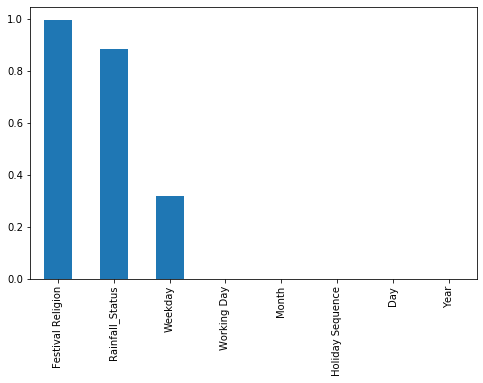

In [14]:
plt.figure(figsize=(8, 5))
p_values.plot.bar()

<h3> As observed, it seems that Festival Religion, Rainfall_Status and Weekday are all rejected and not considered to be important features! </h3>

## Trying to run basic models by dropping the above mentioned columns

In [49]:
categorical_features_list = ['Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year', 'Weekday', 'Rainfall_Status']

numeric_data = convert_categorical_to_numerical(working_data.drop(['Festival Religion'], axis=1), 
                                                categorical_features_list)

X = numeric_data.drop('Total_Amount_Bin', axis=1)
y = numeric_data['Total_Amount_Bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# model = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)

model = LogisticRegression(max_iter=5000, n_jobs=-1)

# model = SVC()

# model = RandomForestClassifier(n_jobs=-1)

# model = MultinomialNB()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
bal_accuracy = balanced_accuracy_score(y_test, predictions, adjusted=True)

print(accuracy)
print(bal_accuracy)

0.21074964639321075
0.07653591311752307


## Preliminary Conclusions
<p> The surprising thing is that this actually doesn't seem to affect the accuracy that much at all, it still pretty much hovers around the 18-22% ish mark and although our accuracy metric is not perfect and we are just measuring on the test set directly without any changes, this definitely is hinting to the fact that Festival Religion, Rainfall_Status and Weekday are not important at all </p>

## Further Conclusions
<p> I tried running the model with and without some of the features that were pointed out by the Chi-Squared Test and it turns out the model with no Festival Religion outperformed any model with any subset of the listed features, so basically it looks like Festival Religion can actually be dropped without worry of negatively affecting our model </p>

<p> All these results were obtained by using only LogisticRegression, keeping train_test_split with random_state=42 so there's no variation there and first number is the accuracy_score metric and the second number is the balanced_accuracy_score metric </p>

<h3> For model with all features </h3>
0.2051<br>
0.07232

<h3> For model with no Festival Religion, Weekday and Rainfall_Status </h3>
0.1909<br>
0.0599

<h3>  For model with no Festival Religion and Rainfall_Status </h3>
0.2023<br>
0.0692

<h3>  For model with no Festival Religion </h3>
0.2107<br>
0.0765

<h3>  For model with no Weekday and Rainfall_Status </h3>
0.1909<br>
0.0599


<a name="rfe"></a>
## Trying to use Recursive Feature Elimination (RFE)
<p> It is a greedy optimization algorithm which aims to find the best performing feature subset. It repeatedly creates models and keeps aside the best or the worst performing feature at each iteration. It constructs the next model with the left features until all the features are exhausted. It then ranks the features based on the order of their elimination. </p>

## Selecting 30 Best Features from entire dataset

In [76]:
estimator = LogisticRegression(max_iter=5000, n_jobs=-1)
selector = RFE(estimator, n_features_to_select=30, step=1)

categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 
                             'Month', 'Day', 'Year', 'Rainfall_Status']

numeric_data = convert_categorical_to_numerical(working_data, categorical_features_list)

X = numeric_data.drop('Total_Amount_Bin', axis=1)
y = numeric_data['Total_Amount_Bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fits training data on the estimator by using only the best n_features provided (in our case, 30)
selector = selector.fit(X_train, y_train)

predictions = selector.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
bal_accuracy = balanced_accuracy_score(y_test, predictions, adjusted=True)

# selector.support_ is a Boolean Mask which tells you which columns were selected for fitting the data
selected_features = []
for feature, mask in zip(X.columns, selector.support_):
    if mask == True:
        selected_features.append(feature)

print("Selected Features:", selected_features)
print("\nAccuracy:", accuracy)
print("Balanced Accuracy:", bal_accuracy)

Selected Features: ['Weekday_MONDAY', 'Festival Religion_M', 'Festival Religion_NH', 'Holiday Sequence_HWH', 'Holiday Sequence_WHW', 'Month_6', 'Month_10', 'Month_11', 'Month_12', 'Day_3', 'Day_4', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_17', 'Day_18', 'Day_20', 'Day_24', 'Day_25', 'Day_31', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017']

Accuracy: 0.21357850070721357
Balanced Accuracy: 0.06891289964192623


## Selecting 30 Best Features from dataset that has no Festival Religion

In [79]:
estimator = LogisticRegression(max_iter=5000, n_jobs=-1)
selector = RFE(estimator, n_features_to_select=30, step=1)

categorical_features_list = ['Weekday', 'Working Day', 'Holiday Sequence', 
                             'Month', 'Day', 'Year', 'Rainfall_Status']

numeric_data = convert_categorical_to_numerical(working_data.drop('Festival Religion', axis=1), categorical_features_list)

X = numeric_data.drop('Total_Amount_Bin', axis=1)
y = numeric_data['Total_Amount_Bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

selector = selector.fit(X_train, y_train)

predictions = selector.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
bal_accuracy = balanced_accuracy_score(y_test, predictions, adjusted=True)

selected_features = []
for feature, mask in zip(X.columns, selector.support_):
    if mask == True:
        selected_features.append(feature)

print("Selected Features:", selected_features)
print("\nAccuracy:", accuracy)
print("Balanced Accuracy:", bal_accuracy)

Selected Features: ['Weekday_MONDAY', 'Holiday Sequence_HWH', 'Month_6', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Day_3', 'Day_4', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_15', 'Day_17', 'Day_18', 'Day_20', 'Day_24', 'Day_25', 'Day_31', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017']

Accuracy: 0.214992927864215
Balanced Accuracy: 0.07102083897062214


<p> As expected, removing Festival Religion still has a marginal improvement on the overall accuracy and atleast noticeable improvement on the Balanced Accuracy which is a raw measure but still I think its indicative of the fact that Festival Religion doesn't really contribute much </p>

<a name="categorical-hyperparameter-tuning"></a>
## Hyperparameter Tuning for Categorical Output Data

In [58]:
# Works for both RandomizedSearchCV() object and GridSearchCV() object
def categorical_model_training_hyperparam(models, atm_data, categorical_features_list):
    numeric_curr_atm_data = convert_categorical_to_numerical(atm_data, categorical_features_list)

    X = numeric_curr_atm_data.drop('Total_Amount_Bin', axis=1)
    y = numeric_curr_atm_data['Total_Amount_Bin']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    for model in models:
        print("For Model:", model)
        param_cv_obj = models[model]
        param_cv_obj.fit(X_train, y_train)
        print("Best Parameters:\n", param_cv_obj.best_params_)
        print("\nBest CV Score:", param_cv_obj.best_score_)
        if 'mean_train_score' in param_cv_obj.cv_results_:
            # nanmean() is used here instead of mean() because for DecisionTree the mean_train_score actually contains nan
            # for some reason, so nanmean() ignores it while computing mean
            print("Best Training Score:", np.nanmean(param_cv_obj.cv_results_['mean_train_score']))

        best_model = param_cv_obj.best_estimator_
        model_predictions = best_model.predict(X_test)
        # model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
        model_accuracy = accuracy_score(y_test, model_predictions)

        print("Test Accuracy:", model_accuracy)
        print("------------------------------------------------------------------------")    

## Defining Parameter Grids and setting up the models dictionary

In [67]:
svr_param_grid = {
    'C': list(np.logspace(-3, 5, num=25)), 
}

random_cv_svr = RandomizedSearchCV(SVC(), svr_param_grid, n_iter=50, cv=10, verbose=2, 
                                   n_jobs=-1, scoring='accuracy', return_train_score=True)

knn_param_grid = {
    'n_neighbors': list(range(1,50)), 
    'leaf_size': list(range(1,50)), 
    'p': [1, 2]
}
                      
random_cv_knn = RandomizedSearchCV(KNeighborsClassifier(), knn_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='accuracy', verbose=2, cv=10, return_train_score=True)

rforest_param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
    'min_samples_split': list(range(1,40)), 
    'min_samples_leaf': list(range(1,25))
}
                      
random_cv_rforest = RandomizedSearchCV(RandomForestClassifier(), rforest_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='accuracy', verbose=2, cv=10, return_train_score=True)

lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'lbfgs']
}

random_cv_lr = RandomizedSearchCV(LogisticRegression(), lr_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='accuracy', verbose=2, cv=10, return_train_score=True)

models = {
    'K-Nearest Neighbours': random_cv_knn,
    'Support Vector Regression': random_cv_svr, 
    'Random Forest Regression': random_cv_rforest, 
    'Logistic Regression': random_cv_lr
}

## Running hyperparameter tuning for all above models with "accuracy" as the metric

In [68]:
categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 
                             'Month', 'Day', 'Year', 'Rainfall_Status']

categorical_model_training_hyperparam(models, working_data, categorical_features_list)

For Model: K-Nearest Neighbours
Fitting 10 folds for each of 25 candidates, totalling 250 fits


c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   41.5s finished
c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:277: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less 

Best Parameters:
 {'p': 2, 'n_neighbors': 19, 'leaf_size': 42}

Best CV Score: 0.1590613451589061
Best Training Score: 0.3117040211920433
Test Accuracy: 0.15983026874115983
------------------------------------------------------------------------
For Model: Support Vector Regression
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   59.8s finished


Best Parameters:
 {'C': 1.0}

Best CV Score: 0.19489652623798964
Best Training Score: 0.6604870311574362
Test Accuracy: 0.2248939179632249
------------------------------------------------------------------------
For Model: Random Forest Regression
Fitting 10 folds for each of 25 candidates, totalling 250 fits


c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.6min finished


Best Parameters:
 {'n_estimators': 400, 'min_samples_split': 15, 'min_samples_leaf': 17}

Best CV Score: 0.20337028824833703
Best Training Score: 0.4069570853842423
Test Accuracy: 0.2347949080622348
------------------------------------------------------------------------
For Model: Logistic Regression
Fitting 10 folds for each of 25 candidates, totalling 250 fits


c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    4.4s


Best Parameters:
 {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.08858667904100823}

Best CV Score: 0.2034109386548411
Best Training Score: 0.296187069763036
Test Accuracy: 0.2164073550212164
------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   34.6s finished


## Conclusion:
## The class imbalance is way too strong such that we can't really solve it. So it is better to do regression first and then bin result into classes so that we can give it to bank 

## Back to Regression!
<a name="sequential-train-test"></a>
## Using Sequential Train Test Split instead of Randomized Split

In [8]:
combined_data = pd.read_csv('../data/aggregated_atm_data_with_weather_data.csv ')
combined_data.drop(['No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals', 
                    'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card',
                    'maxtempC', 'HeatIndexC', 'WindChillC', 'tempC', 'WindGustKmph', 'DewPointC'], axis=1, inplace=True)

combined_data['Transaction Date'] = pd.to_datetime(combined_data['Transaction Date'])
combined_data['Day'] = combined_data['Transaction Date'].dt.day
combined_data['Month'] = combined_data['Transaction Date'].dt.month
combined_data['Year'] = combined_data['Transaction Date'].dt.year
combined_data.drop('Transaction Date', axis=1, inplace=True)

combined_data.drop(['moonrise', 'moonset', 'sunrise', 'sunset', 'winddirDegree', 
                    'mintempC', 'uvIndex', 'sunHour', 'FeelsLikeC', 'cloudcover',
                   'humidity', 'pressure', 'visibility', 'winddirDegree', 
                    'windspeedKmph', 'moon_illumination'], axis=1, inplace=True)

def rainfall_status_check(value):
    if value == 0:
        return "No Rain"
    elif value < 2.5:
        return "Light Rain"
    elif value <= 7.6:
        return "Moderate Rain"
    elif value <= 50:
        return "Heavy Rain"
    else:
        return "Violent Rain"
    
combined_data['Rainfall_Status'] = combined_data['precipMM'].apply(rainfall_status_check)
combined_data.drop('precipMM', axis=1, inplace=True)

In [14]:
rforest_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
                      'min_samples_split': list(range(1,40)), 'min_samples_leaf': list(range(1,25))}

random_cv_rforest = RandomizedSearchCV(RandomForestRegressor(), rforest_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)

categorical_features_list = ['Weekday', 'Holiday Sequence', 'Working Day', 'Festival Religion',
                             'Month', 'Day', 'Year', 'Rainfall_Status']

model_training_hyperparam_per_atm("Big Street ATM", combined_data, 
                                  categorical_features_list, random_cv_rforest, tree_model=True)

Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  8.5min finished


Best Parameters:
 {'n_estimators': 600, 'min_samples_split': 25, 'min_samples_leaf': 4}

Best CV RMSE: 97959.82148385582
Best Training RMSE: 83858.71997061197
Test RMSE: 276759.81347742316
Test MAPE: 222.10761981887487
Year_2015: 0.255 +/- 0.055
Month_5 : 0.016 +/- 0.006
Month_6 : 0.006 +/- 0.001
Day_9   : 0.004 +/- 0.001
Day_4   : 0.004 +/- 0.001
Day_6   : 0.003 +/- 0.000
Holiday Sequence_WHH: 0.003 +/- 0.001
Day_3   : 0.002 +/- 0.001
Day_26  : 0.001 +/- 0.001
Month_11: 0.001 +/- 0.001
Weekday_SATURDAY: 0.001 +/- 0.000
Day_31  : 0.000 +/- 0.000
------------------------------------------------------------------------



## Dropping Festival Religion column and rerunning Lasso and Random Forest
<p> The Chi-Squared Test indicated that Festival Religion was the least important column so more focus is on it here </p>

In [11]:
rforest_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
                      'min_samples_split': list(range(1,40)), 'min_samples_leaf': list(range(1,25))}

random_cv_rforest = RandomizedSearchCV(RandomForestRegressor(), rforest_param_grid, n_iter=25, n_jobs=-1, 
                                      scoring='neg_root_mean_squared_error', verbose=2, cv=10, return_train_score=True)

categorical_features_list = ['Weekday', 'Holiday Sequence', 'Working Day', 
                             'Month', 'Day', 'Year', 'Rainfall_Status']

model_training_hyperparam_per_atm("Big Street ATM", combined_data.drop("Festival Religion", axis=1), 
                                  categorical_features_list, random_cv_rforest, tree_model=True)

Using Train-Test Split
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.9min finished


Best Parameters:
 {'n_estimators': 200, 'min_samples_split': 38, 'min_samples_leaf': 5}

Best CV RMSE: 97914.47364413763
Best Training RMSE: 83503.04583525786
Test RMSE: 277328.5040999877
Test MAPE: 223.19753508063764
Year_2015: 0.255 +/- 0.053
Month_5 : 0.017 +/- 0.006
Month_6 : 0.005 +/- 0.001
Day_9   : 0.003 +/- 0.001
Month_9 : 0.003 +/- 0.001
Holiday Sequence_WHH: 0.003 +/- 0.000
Day_4   : 0.002 +/- 0.001
Month_11: 0.002 +/- 0.000
Day_6   : 0.002 +/- 0.000
Weekday_SATURDAY: 0.002 +/- 0.000
Day_3   : 0.001 +/- 0.000
------------------------------------------------------------------------



In [81]:
lasso_param_grid = {'alpha':np.logspace(-3, 3, num=50)}
grid_cv_lasso = GridSearchCV(Lasso(max_iter=2000), lasso_param_grid, verbose=2, n_jobs=-1, 
                             scoring='neg_root_mean_squared_error', cv=10, return_train_score=True)

categorical_features_list = ['Weekday', 'Holiday Sequence', 'Working Day', 
                             'Month', 'Day', 'Year', 'Rainfall_Status']

model_training_hyperparam_per_atm("Big Street ATM", combined_data.drop("Festival Religion", axis=1), 
                                  categorical_features_list, grid_cv_lasso, tree_model=False)

Using Train-Test Split
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.4s


Best Parameters:
 {'alpha': 244.205309454865}

Best CV RMSE: 88456.27601575704
Best Training RMSE: 78817.93813921516
Test RMSE: 262201.0970369484
Test MAPE: 523.3419229815353
------------------------------------------------------------------------



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.5s finished


## Conclusions:
<p> Quite low Training RMSE and not bad CV RMSE albeit seems quite close to overfitting, the problem lies with Test RMSE which is really, really high in comparison. So that is not optimal. </p>

<p> Maybe this points towards using models that are only trained on recent data and doesn't give that much importance to past data or isn't even trained on past data because of how much the average withdrawal amount increases as the years go by </p>